In [2]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

import dijkstra as dijk
import stacked_graph as sg
import testing as test
import graph_visualization as gv

In [3]:

read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict

graph = sg.StackedGraph(raw_json=raw_json)

In [4]:
groups = list(graph.get_node_groups(ASAP = False))
print(test.group_validate(graph, groups))
print(groups[0])
print(groups[2])


True
[14, 18, 16, 19]
[71, 72, 73, 75, 76, 78, 79, 80, 82, 84, 85, 87, 89, 90, 94, 96, 97, 99, 100, 102, 92, 103, 104, 106, 108, 109, 110]


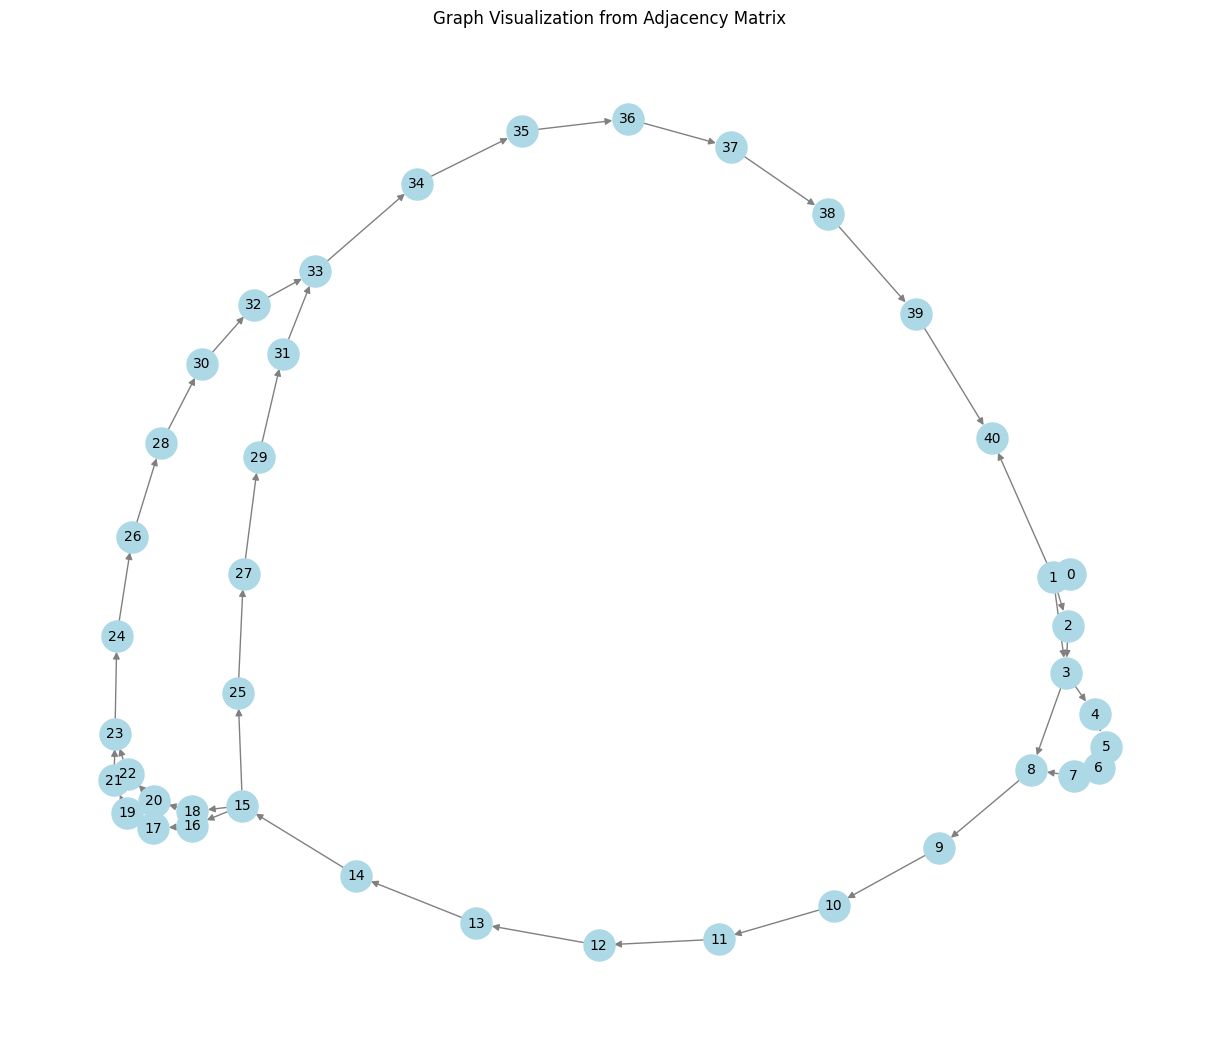

In [5]:
for i in range(len(groups)):
    if i == 3:
        test_group = groups[i]

        start_stack = sg.StackedNode(0, [], [[]], [[]], opp='start', func_stack=['start'], cost_stack=[0])
        first_stack = copy.deepcopy(graph.stack_list[graph.id_to_idx[test_group[0]]])
        first_stack.parents = [0]

        subgraph_stack_list = [start_stack, first_stack]
        for stack_id in test_group[1:]:
            stack = graph.stack_list[graph.id_to_idx[stack_id]]
            new_node = copy.deepcopy(stack)
            new_node.parents = set(new_node.parents) - graph.load_nodes
            subgraph_stack_list.append(new_node)


        new_graph = sg.StackedGraph(stack_list=subgraph_stack_list)
        gv.adj_to_graph(new_graph.adj_matrix, save=False, layout = 'spectral')